# MANUela Anomaly ML Model

Goal: Build a machine lerning model that detects anomalies in sensor vibration data

![anomalies](https://raw.githubusercontent.com/sa-mw-dach/manuela/master/docs/images/manuela-anomalies.png)

Steps:
- Wrangling sensor data 
- Save the training data
- Prepare the data for modeling, training and testing
- Train and validate models
- Select and save the best model
- Prototype class for Seldon model serving

*Note: There are many ways to address the problem. ARIMA. baslining or forecasting with an LSTM neural network would be interesting. In this notebook we picked a rather simple approach, because the focus is on real-time alerts.*

In [1]:
!pip install fbprophet

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python2 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import random
import warnings
import math
import json as JS
from json import load
from json import loads
from datetime import datetime
from fbprophet import Prophet

## Wrangling sensor data

In [3]:
df = pd.read_csv('raw-data.csv')
df['ds'] = pd.to_datetime(df['ts'], unit='ms')
df.set_index('ds', inplace=True)
df.drop(columns=['ts'], inplace=True)

In [4]:
df.head()

,id,value,label
ds,,,
2020-04-23 11:13:54.617,pump-1,18.340181,0
2020-04-23 11:13:57.999,pump-2,12.703972,0
2020-04-23 11:13:59.618,pump-1,17.647661,0
2020-04-23 11:14:02.999,pump-2,13.805114,0
2020-04-23 11:14:04.617,pump-1,16.874933,0


## Raw data over time
Vibration pump 1: Data shows a few anomalies

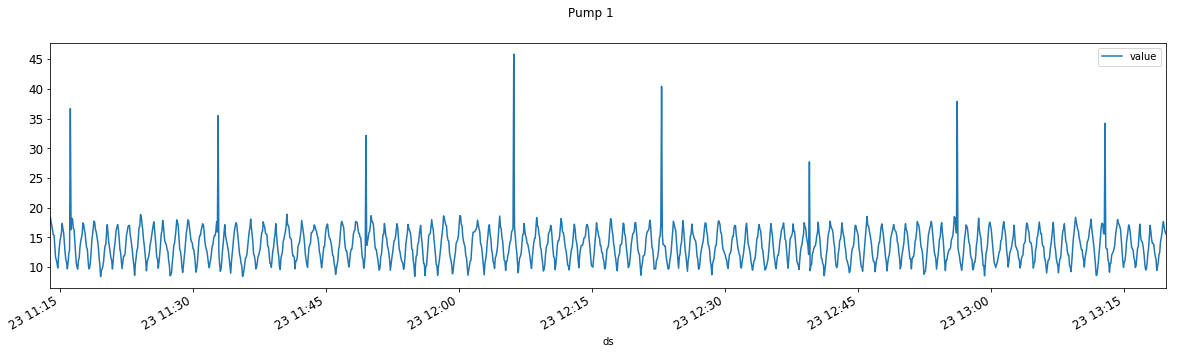

In [5]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id','label'])
df1.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

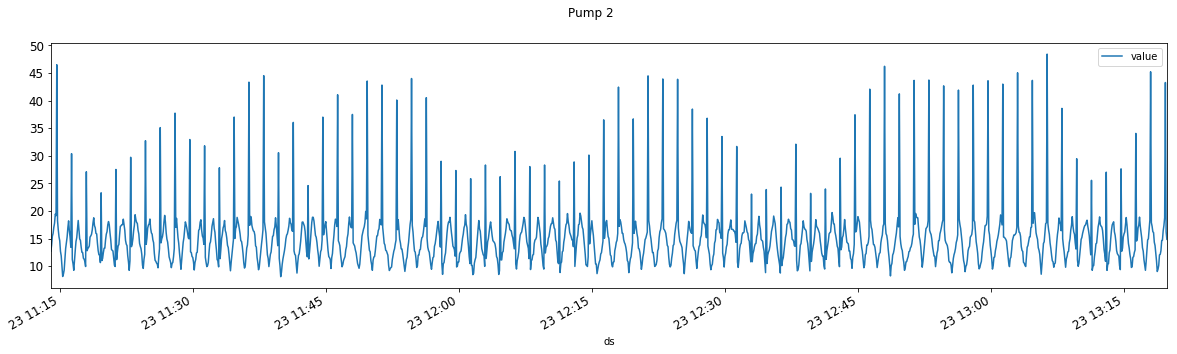

In [6]:
df2 = df.loc[df['id'] == 'pump-2']
df2 = df2.drop(columns=['id','label'])
df2.plot(figsize=(20,5),  fontsize=12,subplots=True,  title = "Pump 2")
plt.show()

## Labeled Data Over Time

In [7]:
df1 = df.loc[df['id'] == 'pump-1']
df1 = df1.drop(columns=['id'])
df1.tail(303)

,value,label
ds,,
2020-04-23 12:54:34.618,14.653942,0
2020-04-23 12:54:39.617,12.808916,0
2020-04-23 12:54:44.617,10.895276,0
2020-04-23 12:54:49.617,9.416972,0
2020-04-23 12:54:54.617,11.139089,0
2020-04-23 12:54:59.617,11.159433,0
2020-04-23 12:55:04.617,12.020030,0
2020-04-23 12:55:09.617,12.466960,0
2020-04-23 12:55:14.617,12.931558,0


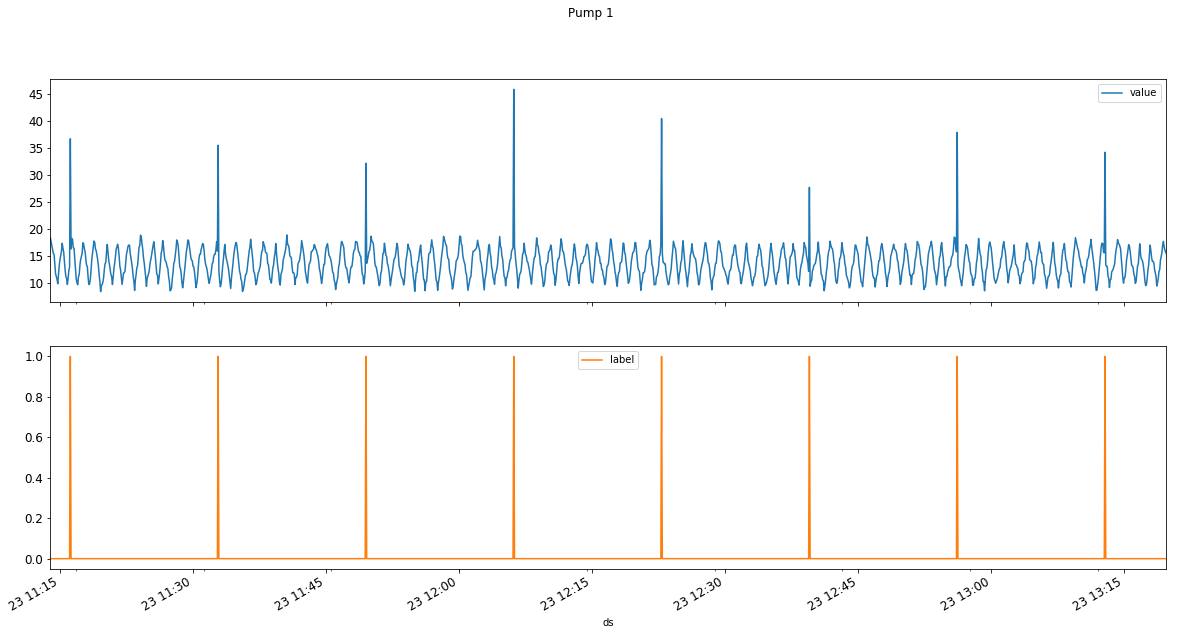

In [8]:
df1.plot(figsize=(20,10),  fontsize=12,subplots=True,  title = "Pump 1")
plt.show()

In [9]:
df2 = df.loc[df['id'] == 'pump-2']
df2 = df2.drop(columns=['id'])
df2.head()

,value,label
ds,,
2020-04-23 11:13:57.999,12.703972,0
2020-04-23 11:14:02.999,13.805114,0
2020-04-23 11:14:07.999,15.415206,0
2020-04-23 11:14:12.999,15.922729,0
2020-04-23 11:14:17.999,17.051560,0


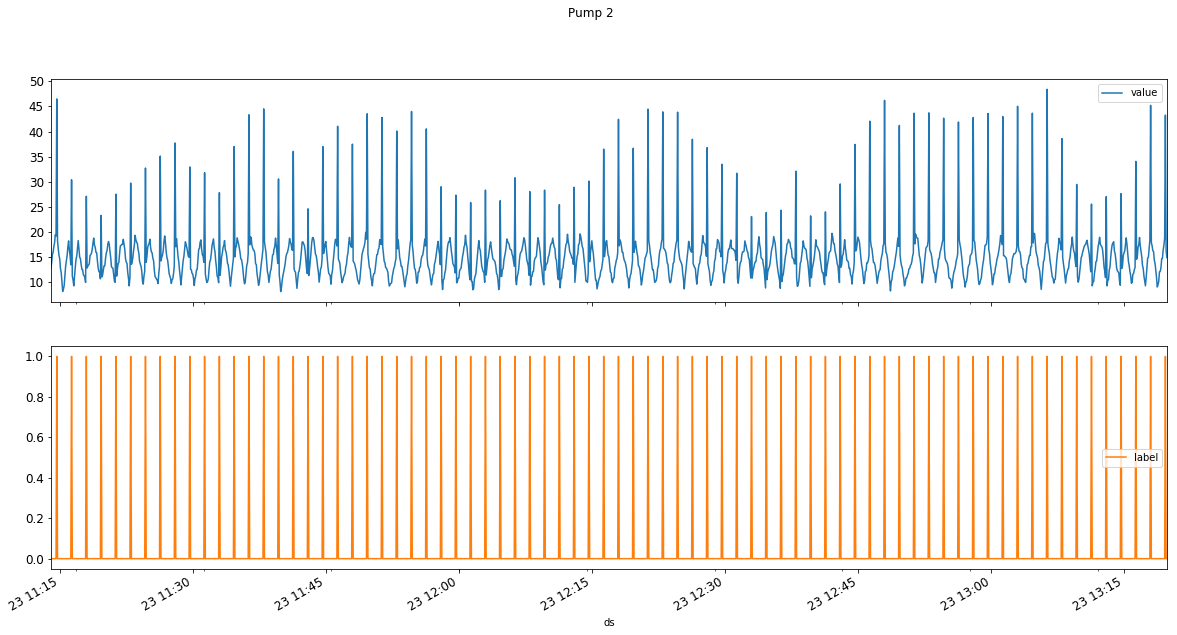

In [10]:
df2.plot(figsize=(20,10),  fontsize=12,subplots=True,  title = "Pump 2")
plt.show()

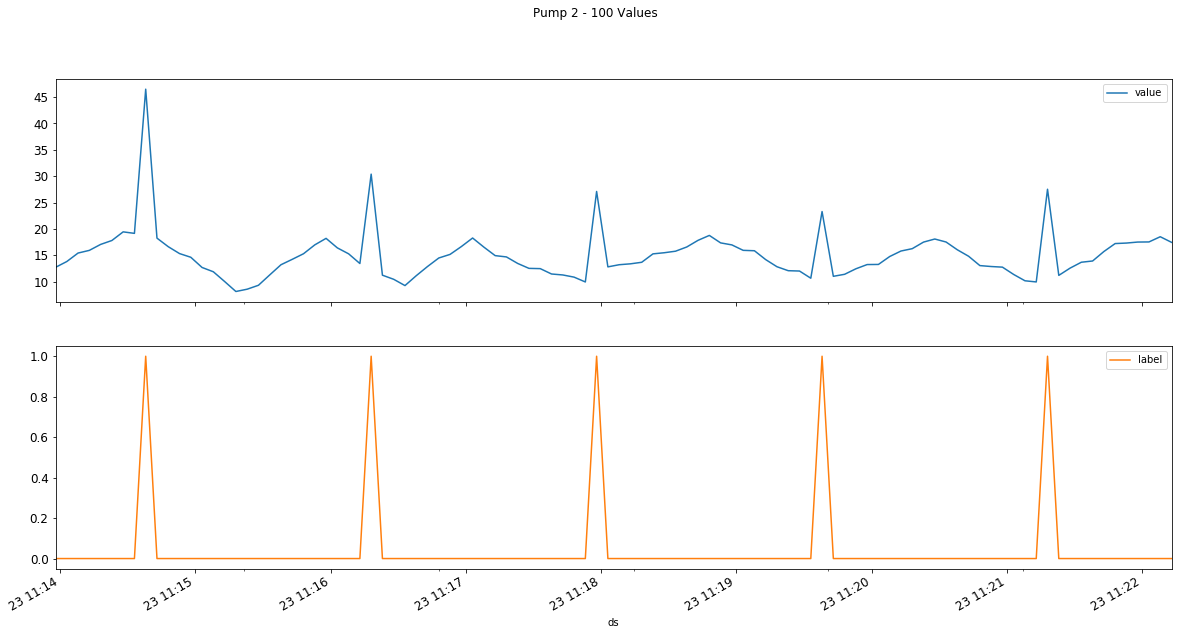

In [11]:
df21 = df2.head(100)
df21.plot(figsize=(20,10), fontsize=12,subplots=True, title = "Pump 2 - 100 Values")
plt.show()

In [12]:
df1 = df1.drop(columns=['label'])

In [13]:
df1.head()

,value
ds,
2020-04-23 11:13:54.617,18.340181
2020-04-23 11:13:59.618,17.647661
2020-04-23 11:14:04.617,16.874933
2020-04-23 11:14:09.617,16.180807
2020-04-23 11:14:14.618,15.407113


In [14]:
df2 = df2.drop(columns=['label'])
df2.head()

,value
ds,
2020-04-23 11:13:57.999,12.703972
2020-04-23 11:14:02.999,13.805114
2020-04-23 11:14:07.999,15.415206
2020-04-23 11:14:12.999,15.922729
2020-04-23 11:14:17.999,17.051560


In [15]:
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by = 'ds')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [16]:
train, test = split_data(df1)

In [17]:
len(train)

1208

In [18]:
len(test)

303

In [19]:
train = train.rename(columns={"value": "y"})
train = train.reset_index()
train.head()

,ds,y
0,2020-04-23 11:13:54.617,18.340181
1,2020-04-23 11:13:59.618,17.647661
2,2020-04-23 11:14:04.617,16.874933
3,2020-04-23 11:14:09.617,16.180807
4,2020-04-23 11:14:14.618,15.407113


In [20]:
test = test.rename(columns={"value": "y"})
test = test.reset_index()
test.head()

,ds,y
0,2020-04-23 12:54:34.618,14.653942
1,2020-04-23 12:54:39.617,12.808916
2,2020-04-23 12:54:44.617,10.895276
3,2020-04-23 12:54:49.617,9.416972
4,2020-04-23 12:54:54.617,11.139089


## Prophet Model

In [21]:
def train_prophet(data):
    model = Prophet()
    model.fit(data)
    return model

In [22]:
def predict_prophet(model, future_time):
    forecast = model.predict(future_time)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [23]:
model = train_prophet(train)

/home/hemaveeradhi/.local/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
forecast = predict_prophet(model,test)

In [25]:
len(forecast)

303

In [26]:
forecast.head(2)

,ds,yhat,yhat_lower,yhat_upper
0,2020-04-23 12:54:34.618,13.551890,9.895439,17.488952
1,2020-04-23 12:54:39.617,13.551659,9.789557,17.497261


## Detecting Anomalies

In [27]:
def forecast_anomalies(forecast_df, signal_df):
    detections = []
    for y, yhat_upper, yhat_lower in zip(signal_df.y,forecast_df.yhat_upper, forecast_df.yhat_lower):
        
        if y <= yhat_lower:
            detections.append(1)
        
        elif y >= yhat_upper:
            detections.append(1)
        
        else:
            detections.append(0)
    
    detected_df = forecast_df
    detected_df["predicted_anomaly"] = detections
    return detected_df    

In [28]:
forecasted_anomalies = forecast_anomalies(forecast,test)

In [29]:
forecasted_anomalies.head(2)

,ds,yhat,yhat_lower,yhat_upper,predicted_anomaly
0,2020-04-23 12:54:34.618,13.551890,9.895439,17.488952,0
1,2020-04-23 12:54:39.617,13.551659,9.789557,17.497261,0


## Saving the trained model

In [30]:
import pickle
pickle.dump(model, open('trained_model.pkl', 'wb'))

In [31]:
loaded_model = pickle.load(open('trained_model.pkl', 'rb'))
loaded_model

## Check the model into Git

In [32]:
!git add 'trained_model.pkl'
!git commit -m 'Updating the anomaly detection trained model.'
!git push

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
	modified:   AnomalyDetection.py
	modified:   Anomaly_Detection.ipynb

no changes added to commit
Everything up-to-date


### Perform forecasting using the trained model and detect anomalies

In [33]:
forecast = predict_prophet(loaded_model,test)
forecasted_anomalies = forecast_anomalies(forecast,test)

In [34]:
forecasted_anomalies.head(2)

,ds,yhat,yhat_lower,yhat_upper,predicted_anomaly
0,2020-04-23 12:54:34.618,13.551890,9.692868,17.400009,0
1,2020-04-23 12:54:39.617,13.551659,9.995678,17.375661,0


## Prototype class for Anomaly Detection
Now, lets create a simple python class which can be invoked for performing the anomaly detection i.e. executing everything explained above in the notebook, but defining it in functions within a class.

In [35]:
import os, sys
import pickle

class AnomalyDetection(object):
    def __init__(self):
        print("Initializing...")
        self.model_file = os.environ.get('MODEL_FILE', 'trained_model.pkl')

        print("Load modelfile: %s" % (self.model_file))
        print("\n")
        self.model = pickle.load(open(self.model_file, 'rb'))

    def predict(self, X):
        prediction = self.model.predict(X)
        
        return prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    def forecast_anomalies(self, forecast_df, signal_df):
        detections = []
        for y, yhat_upper, yhat_lower in zip(signal_df.y, forecast_df.yhat_upper, forecast_df.yhat_lower):
        
            if y <= yhat_lower:
                detections.append(1)
        
            elif y >= yhat_upper:
                detections.append(1)
        
            else:
                detections.append(0)
    
        detected_df = forecast_df
        detected_df["predicted_anomaly"] = detections
        return detected_df    

In [36]:
sample_X = test.head(2)
sample_X

,ds,y
0,2020-04-23 12:54:34.618,14.653942
1,2020-04-23 12:54:39.617,12.808916


In [37]:
p = AnomalyDetection()
    
X = sample_X

print("Actual Data: ", X)
print("\n")

forecast = p.predict(X)
print("Forecast: " , forecast)
print("\n")

anomalies = p.forecast_anomalies(forecast, X)
anomalies = anomalies.rename(columns={"yhat" : "predicted_value"})
anomalies.head()
print("Anomalies: " , anomalies[['predicted_anomaly']] )

Initializing...
Load modelfile: trained_model.pkl


Actual Data:                         ds          y
0 2020-04-23 12:54:34.618  14.653942
1 2020-04-23 12:54:39.617  12.808916


Forecast:                         ds       yhat  yhat_lower  yhat_upper
0 2020-04-23 12:54:34.618  13.551890    9.566959   17.055978
1 2020-04-23 12:54:39.617  13.551659    9.496955   17.477625


Anomalies:     predicted_anomaly
0                  0
1                  0
